In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

    
def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot
    
tf.__version__

Using TensorFlow backend.


'1.12.0'

### Getting data from csv

In [2]:
filename = "cleaned_ADNI.csv"
raw_data = pd.read_csv(filename)
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 299 entries, PTID to DX_bl
dtypes: float64(148), int64(148), object(3)
memory usage: 334.1+ KB
None


,PTID,scandate,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,...,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh,DX_bl
0,094_S_2216,2011-05-04 08:35:04.461,936,1.984,1158,2.107,993,2.306,1226,2.359,...,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579,EMCI
1,029_S_2376,2011-07-05 18:17:58.518,855,2.160,1291,2.287,1137,1.961,1451,2.059,...,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642,EMCI
2,098_S_4003,2016-05-04 15:44:47.525,849,2.122,909,2.272,788,2.430,717,2.606,...,2.222,626,1.870,784,1.826,3182,2.056,195,2.179,CN
3,021_S_2077,2014-10-21 15:26:50.834,762,2.237,969,2.141,1153,2.130,1156,2.135,...,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826,EMCI
4,021_S_5099,2013-06-11 14:47:47.885,752,2.073,960,2.521,873,2.374,810,2.481,...,3.412,790,2.276,665,2.535,2914,2.168,183,2.166,EMCI


**Should do some form of test train split**

We'll start with a (stratified) shuffle split for now. Startified sampling ensures that **test** set has the correct representation of each category.

Later move on to K-Folds to really test out the network...

In [3]:
label_col = "DX_bl"
features = raw_data.drop(columns=["PTID", "scandate",label_col])
labels = raw_data[label_col].copy()
features.head()

,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_SA_lh,G_and_S_transv_frontopol_TH_lh,...,S_suborbital_SA_rh,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh
0,936,1.984,1158,2.107,993,2.306,1226,2.359,443,2.338,...,254,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579
1,855,2.160,1291,2.287,1137,1.961,1451,2.059,685,2.207,...,309,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642
2,849,2.122,909,2.272,788,2.430,717,2.606,474,2.456,...,250,2.222,626,1.870,784,1.826,3182,2.056,195,2.179
3,762,2.237,969,2.141,1153,2.130,1156,2.135,421,2.282,...,180,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826
4,752,2.073,960,2.521,873,2.374,810,2.481,460,2.331,...,197,3.412,790,2.276,665,2.535,2914,2.168,183,2.166


In [4]:
labels.value_counts()/len(labels)

EMCI    0.321678
CN      0.209790
AD      0.181818
LMCI    0.146853
SMC     0.139860
Name: DX_bl, dtype: float64

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

# The train set will have equal amounts of each target class
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(features, labels):
    X_train = features.loc[train_index]
    y_train = labels.loc[train_index]
    X_test = features.loc[test_index]
    y_test = labels.loc[test_index]

In [34]:
y_test.value_counts()/len(y_test)

EMCI    0.344828
CN      0.206897
AD      0.172414
SMC     0.137931
LMCI    0.137931
Name: DX_bl, dtype: float64

**Get 1 Hot Vector representation of the categorical labels**

In [46]:
# y_train_1hot, y_test_1hot = get1hot(y_train,y_test)
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories="auto", sparse=False)
y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
y_test_1hot = enc.fit_transform([[label] for label in y_test])

print(enc.categories_)
print(y_test[:5])
y_test_1hot[:5]
# X_train.shape[1]

[array(['AD', 'CN', 'EMCI', 'LMCI', 'SMC'], dtype=object)]
96    LMCI
11    LMCI
44    EMCI
1     EMCI
60      CN
Name: DX_bl, dtype: object


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

# Normalizing training inputs

Does not work at all without normalization. The ranges for surface area and thickness are vastly different.

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #x-u/sd
X_train_values = scaler.fit_transform(X_train) # Note that X_train is no longer a dataframe
X_test_values = scaler.fit_transform(X_test)

/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Building the network

We will build a fully connected (slightly) deep network with no drop outs or batch normalization for now

In [115]:
keras.backend.clear_session()
reset_graph()

dnn = keras.models.Sequential()

Dense = keras.layers.Dense

dnn.add(Dense(units = 300, activation="elu", input_dim=X_train.shape[1]))
dnn.add(keras.layers.Dropout(0.5))
dnn.add(Dense(units = 150, activation="elu"))
dnn.add(keras.layers.Dropout(0.5))
dnn.add(Dense(units=50, activation='elu'))
# dnn.add(keras.layers.Dropout(0.3))
dnn.add(Dense(units=5, activation="softmax")) # 5 labels -> logits for now

dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               89100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 255       
Total params: 142,055
Trainable params: 142,055
Non-trainable params: 0
_________________________________________________________________


In [116]:
# tf.keras.losses.CategoricalCrossentropy()

In [117]:
from keras import optimizers

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

dnn.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [118]:
history = dnn.fit(X_train_values, y_train_1hot, epochs=30, batch_size = 20)

Epoch 1/30
114/114 [==============================] - 0s 2ms/step - loss: 2.6034 - acc: 0.2105
Epoch 2/30
114/114 [==============================] - 0s 121us/step - loss: 1.8836 - acc: 0.3947
Epoch 3/30
114/114 [==============================] - 0s 121us/step - loss: 1.4633 - acc: 0.4912
Epoch 4/30
114/114 [==============================] - 0s 135us/step - loss: 1.2639 - acc: 0.4825
Epoch 5/30
114/114 [==============================] - 0s 127us/step - loss: 1.2010 - acc: 0.5702
Epoch 6/30
114/114 [==============================] - 0s 134us/step - loss: 0.8847 - acc: 0.6754
Epoch 7/30
114/114 [==============================] - 0s 130us/step - loss: 0.7317 - acc: 0.7807
Epoch 8/30
114/114 [==============================] - 0s 130us/step - loss: 0.6412 - acc: 0.7544
Epoch 9/30
114/114 [==============================] - 0s 129us/step - loss: 0.7414 - acc: 0.7105
Epoch 10/30
114/114 [==============================] - 0s 133us/step - loss: 0.5550 - acc: 0.7982
Epoch 11/30
114/114 [==========

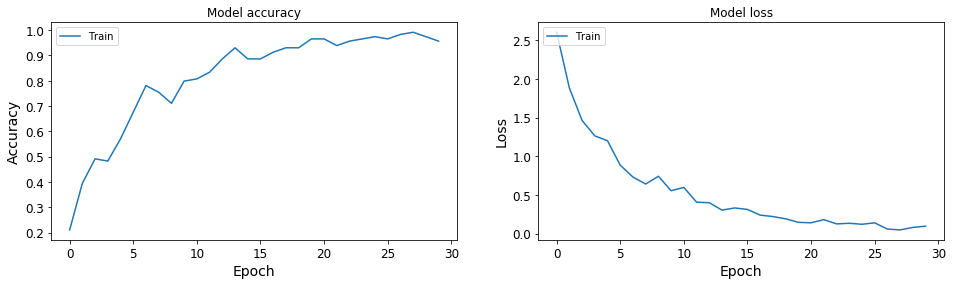

In [119]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(16,4))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)

In [120]:
loss_and_metrics = dnn.evaluate(X_test_values, y_test_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

29/29 [==============================] - 0s 2ms/step
Scores on test set: loss=3.742 accuracy=0.3103
